In [1]:
import config as cf

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import imageio

from sklearn.cluster import DBSCAN
from esda.moran import Moran
from libpysal.weights import lat2W
from scipy.spatial.distance import cdist


from pathlib import Path 

In [2]:
'''
Config params
'''

ADD_ANT_EVERY = 50
INIT_X = 20
INIT_Y = 30

NEST_FACTOR = 0.1

GRID = [40, 40]
GRID_SIZE = np.prod(GRID)

FOCAL_AREA = [3, 3]
FOCAL_SIZE = np.prod(FOCAL_AREA)
ACTION_MAP = [(-1, -1), (0, -1), (1, -1), (-1, 0), (0, 0), (1, 0), (-1, 1), (0, 1), (1, 1)]
OPPOSITE_ACTIONS = list(reversed(range(len(ACTION_MAP))))

FOOD_LOCATION = [40, 5]
FOOD_SIZE = [10, 10]

# WALL_LEFT = 15
# WALL_RIGHT = 25
# WALL_TOP = 10

WALL_LEFT = 0
WALL_RIGHT = 40
WALL_TOP = 10

NUM_PHEROMONE_LEVELS = 10
DECAY_FACTOR = 0.01
# DECAY_FACTOR = 0.005
# DECAY_FACTOR = 1.0

NUM_OBSERVATIONS = NUM_PHEROMONE_LEVELS
NUM_STATES = FOCAL_SIZE
NUM_ACTIONS = FOCAL_SIZE

MAX_LEN = 500

In [3]:
class Ant(object):
    def __init__(self, mdp, init_x, init_y):
        self.mdp = mdp
        self.x_pos = init_x
        self.y_pos = init_y
        self.traj = [(init_x, init_y)]
        self.distance = []
        self.backward_step = 0
        self.is_returning = False
        self.timer = 0
        # self.time_since_last_round_trip = 0
        self.number_of_round_trips = 0

    def update_forward(self, x_pos, y_pos):
        self.x_pos = x_pos
        self.y_pos = y_pos
        self.traj.append((x_pos, y_pos))
        self.distance.append(dis(x_pos, y_pos, cf.INIT_X, cf.INIT_Y))

    def update_backward(self, x_pos, y_pos):
        self.x_pos = x_pos
        self.y_pos = y_pos
        self.distance.append(dis(x_pos, y_pos, cf.INIT_X, cf.INIT_Y))

In [4]:
class Env(object):
    def __init__(self):
        self.visit_matrix = np.zeros((cf.GRID[0], cf.GRID[1]))
        self.obs_matrix = np.zeros((cf.NUM_OBSERVATIONS, cf.GRID[0], cf.GRID[1]))
        # self.obs_matrix[0, :, :] = 1.0
        self.obs_matrix[0, :, :] = 0.0

    def get_A(self, ant):
        A = np.zeros((cf.NUM_OBSERVATIONS, cf.NUM_STATES))
        for s in range(cf.NUM_STATES):
            delta = cf.ACTION_MAP[s]
            A[:, s] = self.obs_matrix[:, ant.x_pos + delta[0], ant.y_pos + delta[1]]
        return A

    def get_obs(self, ant):
        obs_vec = self.obs_matrix[:, ant.x_pos, ant.y_pos]
        return np.argmax(obs_vec)

    def check_food(self, x_pos, y_pos):
        is_food = False
        if (x_pos > (cf.FOOD_LOCATION[0] - cf.FOOD_SIZE[0])) and (
            x_pos < (cf.FOOD_LOCATION[0] + cf.FOOD_SIZE[0])
        ):
            if (y_pos > (cf.FOOD_LOCATION[1] - cf.FOOD_SIZE[1])) and (
                y_pos < (cf.FOOD_LOCATION[1] + cf.FOOD_SIZE[1])
            ):
                is_food = True
        return is_food

    def check_walls(self, orig_x, orig_y, x_pos, y_pos):
        valid = True
        if orig_y > cf.WALL_TOP:
            if orig_x >= cf.WALL_LEFT and x_pos <= cf.WALL_LEFT:
                valid = False
            if orig_x <= cf.WALL_RIGHT and x_pos >= cf.WALL_RIGHT:
                valid = False
        if orig_y <= cf.WALL_TOP:
            if y_pos > cf.WALL_TOP and ((x_pos < cf.WALL_LEFT) or (x_pos > cf.WALL_RIGHT)):
                valid = False
        return valid

    def step_forward(self, ant, action):
        delta = cf.ACTION_MAP[action]
        x_pos = np.clip(ant.x_pos + delta[0], 1, cf.GRID[0] - 2)
        y_pos = np.clip(ant.y_pos + delta[1], 1, cf.GRID[1] - 2)

        if self.check_food(x_pos, y_pos) and np.random.rand() < cf.NEST_FACTOR:
            ant.is_returning = True
            ant.backward_step = 0

        if self.check_walls(ant.x_pos, ant.y_pos, x_pos, y_pos):
            ant.update_forward(x_pos, y_pos)

        """
        if len(ant.traj) > cf.MAX_LEN:
            pos = ant.traj[0]
            ant.update_backward(pos[0], pos[1])
            ant.traj = []
        """

    def step_backward(self, ant):
        path_len = len(ant.traj)
        next_step = path_len - (ant.backward_step + 1)
        pos = ant.traj[next_step]
        ant.update_backward(pos[0], pos[1])

        self.visit_matrix[pos[0], pos[1]] += 1
        curr_obs = np.argmax(self.obs_matrix[:, pos[0], pos[1]])
        curr_obs = min(curr_obs + 1, cf.NUM_OBSERVATIONS - 1)

        self.obs_matrix[:, pos[0], pos[1]] = 0.0
        self.obs_matrix[curr_obs, pos[0], pos[1]] = 1.0

        ant.backward_step += 1
        if ant.backward_step >= path_len - 1:
            ant.is_returning = False
            traj = ant.traj
            ant.traj = []
            return True, traj
        else:
            return False, None

    def decay(self):
        for x in range(cf.GRID[0]):
            for y in range(cf.GRID[1]):
                curr_obs = np.argmax(self.obs_matrix[:, x, y])
                if (curr_obs > 0) and (np.random.rand() < cf.DECAY_FACTOR):
                    curr_obs = curr_obs - 1
                    self.obs_matrix[:, x, y] = 0.0
                    self.obs_matrix[curr_obs, x, y] = 1.0

    # def get_pheromone_values(self):
    #     pheromone_values = []
    #     for x in range(cf.GRID[0]):
    #         for y in range(cf.GRID[1]):
    #             curr_obs = np.argmax(self.obs_matrix[:, x, y])
    #             pheromone_values.append(curr_obs)
    #     return np.array(pheromone_values)

    def get_nonzero_pheromone_locations(self):
        pheromone_locations = []
        for x in range(cf.GRID[0]):
            for y in range(cf.GRID[1]):
                curr_obs = np.argmax(self.obs_matrix[:, x, y])
                # if self.obs_matrix[:, x, y] > 0.0:
                if curr_obs > 0.0:
                    # print(curr_obs)
                    pheromone_locations.append((x, y))
        return np.array(pheromone_locations)

    def get_values(self, ants):
        ant_locations = []
        pheromone_values = []
        for ant in ants:
            ant_locations.append((ant.x_pos, ant.y_pos))
            pheromone_values.append(np.argmax(self.obs_matrix[:, ant.x_pos, ant.y_pos]))
        return np.array(ant_locations), np.array(pheromone_values)
        
    def run_dbscan_on_pheromone_locs(self, eps, min_samples):
        pheromone_locations = self.get_nonzero_pheromone_locations()
        dbscan = DBSCAN(eps = eps, min_samples = min_samples)
        labels = dbscan.fit_predict(pheromone_locations)
        return labels

    def run_dbscan_on_ant_locs(self, eps, min_samples, ants):
        ant_locations, _ = self.get_values(ants)
        dbscan = DBSCAN(eps = eps, min_samples = min_samples)
        labels = dbscan.fit_predict(ant_locations)
        return labels

    def plot(self, ants, savefig=False, name="", ant_only_gif=False):
        x_pos_forward, y_pos_forward = [], []
        x_pos_backward, y_pos_backward = [], []
        for ant in ants:
            if ant.is_returning:
                x_pos_backward.append(ant.x_pos)
                y_pos_backward.append(ant.y_pos)
            else:
                x_pos_forward.append(ant.x_pos)
                y_pos_forward.append(ant.y_pos)

        img = np.ones((cf.GRID[0], cf.GRID[1]))
        fig, ax = plt.subplots()
        ax.imshow(img.T, cmap="gray")
        plot_matrix = np.zeros((cf.GRID[0], cf.GRID[1]))

        for x in range(cf.GRID[0]):
            for y in range(cf.GRID[1]):
                curr_obs = np.argmax(self.obs_matrix[:, x, y])
                plot_matrix[x, y] = curr_obs

        if ant_only_gif == False:
            ax.imshow(plot_matrix.T, alpha=0.7, vmin=0)

        # Overlay the green rectangle for FOOD_LOCATION
        food_x, food_y = cf.FOOD_LOCATION
        food_width, food_height = cf.FOOD_SIZE
        ax.add_patch(plt.Rectangle((food_x, food_y), food_width, food_height, color="green", alpha=0.5))

        if not savefig:
            ax.scatter(x_pos_forward, y_pos_forward, color="red", s=5)
            ax.scatter(x_pos_backward, y_pos_backward, color="blue", s=5)

        if not savefig:
            fig.canvas.draw()
            img = np.frombuffer(fig.canvas.tostring_rgb(), dtype="uint8")
            img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
            plt.close("all")
            return img
        else:
            plt.savefig(name)
        plt.close("all")

In [5]:
class MDP(object):
    def __init__(self, A, B, C):
        self.A = A
        self.B = B
        self.C = C
        self.p0 = np.exp(-16)

        self.num_states = self.A.shape[1]
        self.num_obs = self.A.shape[0]
        self.num_actions = self.B.shape[0]

        self.A = self.A + self.p0
        self.A = self.normdist(self.A)
        self.lnA = np.log(self.A)

        self.B = self.B + self.p0
        for a in range(self.num_actions):
            self.B[a] = self.normdist(self.B[a])

        self.C = self.C + self.p0
        self.C = self.normdist(self.C)

        self.sQ = np.zeros([self.num_states, 1])
        self.uQ = np.zeros([self.num_actions, 1])
        self.prev_action = None
        self.t = 0

    def set_A(self, A):
        self.A = A + self.p0
        self.A = self.normdist(self.A)
        self.lnA = np.log(self.A)

    def reset(self, obs):
        self.t = 0
        self.curr_obs = obs
        likelihood = self.lnA[obs, :]
        likelihood = likelihood[:, np.newaxis]
        self.sQ = self.softmax(likelihood)
        self.prev_action = self.random_action()

    def step(self, obs):
        """ state inference """
        likelihood = self.lnA[obs, :]
        likelihood = likelihood[:, np.newaxis]
        prior = np.dot(self.B[self.prev_action], self.sQ)
        prior = np.log(prior)
        self.sQ = self.softmax(prior)

        """ action inference """
        SCALE = 10
        neg_efe = np.zeros([self.num_actions, 1])
        for a in range(self.num_actions):
            fs = np.dot(self.B[a], self.sQ)
            fo = np.dot(self.A, fs)
            fo = self.normdist(fo + self.p0)
            utility = np.sum(fo * np.log(fo / self.C), axis=0)
            utility = utility[0]
            neg_efe[a] -= utility / SCALE

        # priors
        neg_efe[4] -= 20.0
        neg_efe[cf.OPPOSITE_ACTIONS[self.prev_action]] -= 20.0  # type: ignore

        # action selection
        self.uQ = self.softmax(neg_efe)
        action = np.argmax(np.random.multinomial(1, self.uQ.squeeze()))
        self.prev_action = action
        return action

    def random_action(self):
        return int(np.random.choice(range(self.num_actions)))

    @staticmethod
    def softmax(x):
        x = x - x.max()
        x = np.exp(x)
        x = x / np.sum(x)
        return x

    @staticmethod
    def normdist(x):
        return np.dot(x, np.diag(1 / np.sum(x, 0)))

In [6]:
def create_ant(init_x, init_y, C):
    A = np.zeros((cf.NUM_OBSERVATIONS, cf.NUM_STATES))
    B = np.zeros((cf.NUM_ACTIONS, cf.NUM_STATES, cf.NUM_STATES))
    for a in range(cf.NUM_ACTIONS):
        B[a, a, :] = 1.0
    mdp = MDP(A, B, C)
    ant = Ant(mdp, init_x, init_y)
    return ant


def dis(x1, y1, x2, y2):
    return np.sqrt(((x1 - x2) ** 2) + ((y1 - y2) ** 2))


def plot_path(path, save_name):
    path = np.array(path)
    _, ax = plt.subplots(1, 1)
    ax.set_xlim(cf.GRID[0])
    ax.set_ylim(cf.GRID[1])
    ax.plot(path[:, 0], path[:, 1], "-o", color="red", alpha=0.4)
    plt.savefig(save_name)
    plt.close("all")


def save_gif(imgs, path, fps=32):
    imageio.mimsave(path, imgs, fps=fps)

In [7]:
def main(num_steps, init_ants, max_ants, C, ctr, num_runs, save=True, switch=False, name="", ant_only_gif=False):
    env = Env()
    ants = []
    paths = []
    for _ in range(init_ants):
        ant = create_ant(cf.INIT_X, cf.INIT_Y, C)
        obs = env.get_obs(ant)
        A = env.get_A(ant)
        ant.mdp.set_A(A)
        ant.mdp.reset(obs)
        ants.append(ant)

    imgs = []
    completed_trips = 0

    Morans_i_values = []

    distance = 0
    distances = []

    cluster_density = 0
    cluster_densities = []
    num_clusters = []

    ant_locations = []
    num_round_trips_per_time = []

    num_rt_at_time_t = 0

    for t in range(num_steps):
        t_dis = 0

        for ant in ants:
            for ant_2 in ants:
                t_dis += dis(ant.x_pos, ant.y_pos, ant_2.x_pos, ant_2.y_pos)

        current_avg_dist = t_dis / len(ants)
        distance += current_avg_dist
        distances.append(current_avg_dist)

        ant_positions, pheromone_values = env.get_values(ants)

        # Combine ant locations and pheromone values
        Z = np.column_stack((ant_positions, pheromone_values))

        # Create weight matrix
        w = lat2W(Z.shape[0], Z.shape[1])

        # Create PySAL Moran obj
        m_i = Moran(Z, w)

        # add to the Moran's I list
        Morans_i_values.append(m_i.I)

        if len(paths) == 0:
            cluster_densities.append(0)
            num_clusters.append(0)
        else:

            # ant_trajectory_locations = [point for trajectory in paths for point in trajectory]


            # Create and fit a DBSCAN model
            eps = 5 
            # min_samples = len(ants) // 5
            min_samples = 3
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            dbscan_labels = dbscan.fit_predict(ant_positions)

            # the number of DBSCAN Clusters
            n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)

            # Calculate cluster sizes
            cluster_sizes = [len(ant_positions[dbscan_labels == label]) for label in set(dbscan_labels)]

            # Calculate the average density
            if cluster_sizes:
                average_density = len(ant_positions) / len(cluster_sizes)
            else:
                average_density = 0

            # print("Average Density of Clusters:", average_density)

            cluster_densities.append(average_density)
            num_clusters.append(n_clusters)


        # if t % (num_steps // 100) == 0:
        print(f"Step {t + 1}/{num_steps} of Simulation {ctr + 1}/{num_runs}")

        if t % cf.ADD_ANT_EVERY == 0 and len(ants) < max_ants:
            ant = create_ant(cf.INIT_X, cf.INIT_Y, C)
            obs = env.get_obs(ant)
            A = env.get_A(ant)
            ant.mdp.set_A(A)
            ant.mdp.reset(obs)
            ants.append(ant)

        # if switch and t % (num_steps // 2) == 0:
        #     cf.FOOD_LOCATION[0] = cf.GRID[0] - cf.FOOD_LOCATION[0]

        for ant in ants:
            if not ant.is_returning:
                obs = env.get_obs(ant)
                A = env.get_A(ant)
                ant.mdp.set_A(A)
                action = ant.mdp.step(obs)
                env.step_forward(ant, action)
            else:
                is_complete, traj = env.step_backward(ant)
                completed_trips += int(is_complete)

                if is_complete:
                    paths.append(traj)

                    # increment the number of round trips by 1
                    ant.number_of_round_trips += 1
                    num_rt_at_time_t += 1

        num_round_trips_per_time.append(num_rt_at_time_t)
    
#         if save:
#             if t in np.arange(0, num_steps, num_steps // 20):
#             # if t in np.arange(0, num_steps):
#                 env.plot(ants, savefig=True, name=f"my_imgs_full_sim/{name}_{t}.png")
#             else:
#                 img = env.plot(ants, ant_only_gif=ant_only_gif)
#                 imgs.append(img)

#         # round_trips_over_time.append(completed_trips / max_ants)
#         ant_locations.append([[ant.x_pos, ant.y_pos] for ant in ants])

#     if save:
#         save_gif(imgs, f"my_imgs_full_sim/{name}.gif")


#     ant_locations = np.array(ant_locations)

#     np.save(f"my_imgs_full_sim/{name}_locations", ant_locations)


    return completed_trips, np.array(paths), distance, distances, num_round_trips_per_time, ants, cluster_densities, num_clusters, Morans_i_values

Step 1/500 of Simulation 1/5
Step 2/500 of Simulation 1/5
Step 3/500 of Simulation 1/5
Step 4/500 of Simulation 1/5
Step 5/500 of Simulation 1/5
Step 6/500 of Simulation 1/5
Step 7/500 of Simulation 1/5
Step 8/500 of Simulation 1/5
Step 9/500 of Simulation 1/5
Step 10/500 of Simulation 1/5
Step 11/500 of Simulation 1/5
Step 12/500 of Simulation 1/5
Step 13/500 of Simulation 1/5
Step 14/500 of Simulation 1/5
Step 15/500 of Simulation 1/5
Step 16/500 of Simulation 1/5
Step 17/500 of Simulation 1/5
Step 18/500 of Simulation 1/5
Step 19/500 of Simulation 1/5
Step 20/500 of Simulation 1/5
Step 21/500 of Simulation 1/5
Step 22/500 of Simulation 1/5
Step 23/500 of Simulation 1/5
Step 24/500 of Simulation 1/5
Step 25/500 of Simulation 1/5
Step 26/500 of Simulation 1/5
Step 27/500 of Simulation 1/5
Step 28/500 of Simulation 1/5
Step 29/500 of Simulation 1/5
Step 30/500 of Simulation 1/5
Step 31/500 of Simulation 1/5
Step 32/500 of Simulation 1/5
Step 33/500 of Simulation 1/5
Step 34/500 of Simu

Step 275/500 of Simulation 1/5
Step 276/500 of Simulation 1/5
Step 277/500 of Simulation 1/5
Step 278/500 of Simulation 1/5
Step 279/500 of Simulation 1/5
Step 280/500 of Simulation 1/5
Step 281/500 of Simulation 1/5
Step 282/500 of Simulation 1/5
Step 283/500 of Simulation 1/5
Step 284/500 of Simulation 1/5
Step 285/500 of Simulation 1/5
Step 286/500 of Simulation 1/5
Step 287/500 of Simulation 1/5
Step 288/500 of Simulation 1/5
Step 289/500 of Simulation 1/5
Step 290/500 of Simulation 1/5
Step 291/500 of Simulation 1/5
Step 292/500 of Simulation 1/5
Step 293/500 of Simulation 1/5
Step 294/500 of Simulation 1/5
Step 295/500 of Simulation 1/5
Step 296/500 of Simulation 1/5
Step 297/500 of Simulation 1/5
Step 298/500 of Simulation 1/5
Step 299/500 of Simulation 1/5
Step 300/500 of Simulation 1/5
Step 301/500 of Simulation 1/5
Step 302/500 of Simulation 1/5
Step 303/500 of Simulation 1/5
Step 304/500 of Simulation 1/5
Step 305/500 of Simulation 1/5
Step 306/500 of Simulation 1/5
Step 307

Step 45/500 of Simulation 2/5
Step 46/500 of Simulation 2/5
Step 47/500 of Simulation 2/5
Step 48/500 of Simulation 2/5
Step 49/500 of Simulation 2/5
Step 50/500 of Simulation 2/5
Step 51/500 of Simulation 2/5
Step 52/500 of Simulation 2/5
Step 53/500 of Simulation 2/5
Step 54/500 of Simulation 2/5
Step 55/500 of Simulation 2/5
Step 56/500 of Simulation 2/5
Step 57/500 of Simulation 2/5
Step 58/500 of Simulation 2/5
Step 59/500 of Simulation 2/5
Step 60/500 of Simulation 2/5
Step 61/500 of Simulation 2/5
Step 62/500 of Simulation 2/5
Step 63/500 of Simulation 2/5
Step 64/500 of Simulation 2/5
Step 65/500 of Simulation 2/5
Step 66/500 of Simulation 2/5
Step 67/500 of Simulation 2/5
Step 68/500 of Simulation 2/5
Step 69/500 of Simulation 2/5
Step 70/500 of Simulation 2/5
Step 71/500 of Simulation 2/5
Step 72/500 of Simulation 2/5
Step 73/500 of Simulation 2/5
Step 74/500 of Simulation 2/5
Step 75/500 of Simulation 2/5
Step 76/500 of Simulation 2/5
Step 77/500 of Simulation 2/5
Step 78/50

Step 319/500 of Simulation 2/5
Step 320/500 of Simulation 2/5
Step 321/500 of Simulation 2/5
Step 322/500 of Simulation 2/5
Step 323/500 of Simulation 2/5
Step 324/500 of Simulation 2/5
Step 325/500 of Simulation 2/5
Step 326/500 of Simulation 2/5
Step 327/500 of Simulation 2/5
Step 328/500 of Simulation 2/5
Step 329/500 of Simulation 2/5
Step 330/500 of Simulation 2/5
Step 331/500 of Simulation 2/5
Step 332/500 of Simulation 2/5
Step 333/500 of Simulation 2/5
Step 334/500 of Simulation 2/5
Step 335/500 of Simulation 2/5
Step 336/500 of Simulation 2/5
Step 337/500 of Simulation 2/5
Step 338/500 of Simulation 2/5
Step 339/500 of Simulation 2/5
Step 340/500 of Simulation 2/5
Step 341/500 of Simulation 2/5
Step 342/500 of Simulation 2/5
Step 343/500 of Simulation 2/5
Step 344/500 of Simulation 2/5
Step 345/500 of Simulation 2/5
Step 346/500 of Simulation 2/5
Step 347/500 of Simulation 2/5
Step 348/500 of Simulation 2/5
Step 349/500 of Simulation 2/5
Step 350/500 of Simulation 2/5
Step 351

Step 89/500 of Simulation 3/5
Step 90/500 of Simulation 3/5
Step 91/500 of Simulation 3/5
Step 92/500 of Simulation 3/5
Step 93/500 of Simulation 3/5
Step 94/500 of Simulation 3/5
Step 95/500 of Simulation 3/5
Step 96/500 of Simulation 3/5
Step 97/500 of Simulation 3/5
Step 98/500 of Simulation 3/5
Step 99/500 of Simulation 3/5
Step 100/500 of Simulation 3/5
Step 101/500 of Simulation 3/5
Step 102/500 of Simulation 3/5
Step 103/500 of Simulation 3/5
Step 104/500 of Simulation 3/5
Step 105/500 of Simulation 3/5
Step 106/500 of Simulation 3/5
Step 107/500 of Simulation 3/5
Step 108/500 of Simulation 3/5
Step 109/500 of Simulation 3/5
Step 110/500 of Simulation 3/5
Step 111/500 of Simulation 3/5
Step 112/500 of Simulation 3/5
Step 113/500 of Simulation 3/5
Step 114/500 of Simulation 3/5
Step 115/500 of Simulation 3/5
Step 116/500 of Simulation 3/5
Step 117/500 of Simulation 3/5
Step 118/500 of Simulation 3/5
Step 119/500 of Simulation 3/5
Step 120/500 of Simulation 3/5
Step 121/500 of Sim

Step 354/500 of Simulation 3/5
Step 355/500 of Simulation 3/5
Step 356/500 of Simulation 3/5
Step 357/500 of Simulation 3/5
Step 358/500 of Simulation 3/5
Step 359/500 of Simulation 3/5
Step 360/500 of Simulation 3/5
Step 361/500 of Simulation 3/5
Step 362/500 of Simulation 3/5
Step 363/500 of Simulation 3/5
Step 364/500 of Simulation 3/5
Step 365/500 of Simulation 3/5
Step 366/500 of Simulation 3/5
Step 367/500 of Simulation 3/5
Step 368/500 of Simulation 3/5
Step 369/500 of Simulation 3/5
Step 370/500 of Simulation 3/5
Step 371/500 of Simulation 3/5
Step 372/500 of Simulation 3/5
Step 373/500 of Simulation 3/5
Step 374/500 of Simulation 3/5
Step 375/500 of Simulation 3/5
Step 376/500 of Simulation 3/5
Step 377/500 of Simulation 3/5
Step 378/500 of Simulation 3/5
Step 379/500 of Simulation 3/5
Step 380/500 of Simulation 3/5
Step 381/500 of Simulation 3/5
Step 382/500 of Simulation 3/5
Step 383/500 of Simulation 3/5
Step 384/500 of Simulation 3/5
Step 385/500 of Simulation 3/5
Step 386

/tmp/ipykernel_625508/3419290518.py:142: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return completed_trips, np.array(paths), distance, distances, num_round_trips_per_time, ants, cluster_densities, num_clusters, Morans_i_values


Step 5/500 of Simulation 4/5
Step 6/500 of Simulation 4/5
Step 7/500 of Simulation 4/5
Step 8/500 of Simulation 4/5
Step 9/500 of Simulation 4/5
Step 10/500 of Simulation 4/5
Step 11/500 of Simulation 4/5
Step 12/500 of Simulation 4/5
Step 13/500 of Simulation 4/5
Step 14/500 of Simulation 4/5
Step 15/500 of Simulation 4/5
Step 16/500 of Simulation 4/5
Step 17/500 of Simulation 4/5
Step 18/500 of Simulation 4/5
Step 19/500 of Simulation 4/5
Step 20/500 of Simulation 4/5
Step 21/500 of Simulation 4/5
Step 22/500 of Simulation 4/5
Step 23/500 of Simulation 4/5
Step 24/500 of Simulation 4/5
Step 25/500 of Simulation 4/5
Step 26/500 of Simulation 4/5
Step 27/500 of Simulation 4/5
Step 28/500 of Simulation 4/5
Step 29/500 of Simulation 4/5
Step 30/500 of Simulation 4/5
Step 31/500 of Simulation 4/5
Step 32/500 of Simulation 4/5
Step 33/500 of Simulation 4/5
Step 34/500 of Simulation 4/5
Step 35/500 of Simulation 4/5
Step 36/500 of Simulation 4/5
Step 37/500 of Simulation 4/5
Step 38/500 of 

Step 274/500 of Simulation 4/5
Step 275/500 of Simulation 4/5
Step 276/500 of Simulation 4/5
Step 277/500 of Simulation 4/5
Step 278/500 of Simulation 4/5
Step 279/500 of Simulation 4/5
Step 280/500 of Simulation 4/5
Step 281/500 of Simulation 4/5
Step 282/500 of Simulation 4/5
Step 283/500 of Simulation 4/5
Step 284/500 of Simulation 4/5
Step 285/500 of Simulation 4/5
Step 286/500 of Simulation 4/5
Step 287/500 of Simulation 4/5
Step 288/500 of Simulation 4/5
Step 289/500 of Simulation 4/5
Step 290/500 of Simulation 4/5
Step 291/500 of Simulation 4/5
Step 292/500 of Simulation 4/5
Step 293/500 of Simulation 4/5
Step 294/500 of Simulation 4/5
Step 295/500 of Simulation 4/5
Step 296/500 of Simulation 4/5
Step 297/500 of Simulation 4/5
Step 298/500 of Simulation 4/5
Step 299/500 of Simulation 4/5
Step 300/500 of Simulation 4/5
Step 301/500 of Simulation 4/5
Step 302/500 of Simulation 4/5
Step 303/500 of Simulation 4/5
Step 304/500 of Simulation 4/5
Step 305/500 of Simulation 4/5
Step 306

/tmp/ipykernel_625508/3419290518.py:142: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return completed_trips, np.array(paths), distance, distances, num_round_trips_per_time, ants, cluster_densities, num_clusters, Morans_i_values


Step 1/500 of Simulation 5/5
Step 2/500 of Simulation 5/5
Step 3/500 of Simulation 5/5
Step 4/500 of Simulation 5/5
Step 5/500 of Simulation 5/5
Step 6/500 of Simulation 5/5
Step 7/500 of Simulation 5/5
Step 8/500 of Simulation 5/5
Step 9/500 of Simulation 5/5
Step 10/500 of Simulation 5/5
Step 11/500 of Simulation 5/5
Step 12/500 of Simulation 5/5
Step 13/500 of Simulation 5/5
Step 14/500 of Simulation 5/5
Step 15/500 of Simulation 5/5
Step 16/500 of Simulation 5/5
Step 17/500 of Simulation 5/5
Step 18/500 of Simulation 5/5
Step 19/500 of Simulation 5/5
Step 20/500 of Simulation 5/5
Step 21/500 of Simulation 5/5
Step 22/500 of Simulation 5/5
Step 23/500 of Simulation 5/5
Step 24/500 of Simulation 5/5
Step 25/500 of Simulation 5/5
Step 26/500 of Simulation 5/5
Step 27/500 of Simulation 5/5
Step 28/500 of Simulation 5/5
Step 29/500 of Simulation 5/5
Step 30/500 of Simulation 5/5
Step 31/500 of Simulation 5/5
Step 32/500 of Simulation 5/5
Step 33/500 of Simulation 5/5
Step 34/500 of Simu

Step 270/500 of Simulation 5/5
Step 271/500 of Simulation 5/5
Step 272/500 of Simulation 5/5
Step 273/500 of Simulation 5/5
Step 274/500 of Simulation 5/5
Step 275/500 of Simulation 5/5
Step 276/500 of Simulation 5/5
Step 277/500 of Simulation 5/5
Step 278/500 of Simulation 5/5
Step 279/500 of Simulation 5/5
Step 280/500 of Simulation 5/5
Step 281/500 of Simulation 5/5
Step 282/500 of Simulation 5/5
Step 283/500 of Simulation 5/5
Step 284/500 of Simulation 5/5
Step 285/500 of Simulation 5/5
Step 286/500 of Simulation 5/5
Step 287/500 of Simulation 5/5
Step 288/500 of Simulation 5/5
Step 289/500 of Simulation 5/5
Step 290/500 of Simulation 5/5
Step 291/500 of Simulation 5/5
Step 292/500 of Simulation 5/5
Step 293/500 of Simulation 5/5
Step 294/500 of Simulation 5/5
Step 295/500 of Simulation 5/5
Step 296/500 of Simulation 5/5
Step 297/500 of Simulation 5/5
Step 298/500 of Simulation 5/5
Step 299/500 of Simulation 5/5
Step 300/500 of Simulation 5/5
Step 301/500 of Simulation 5/5
Step 302

/tmp/ipykernel_625508/3419290518.py:142: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return completed_trips, np.array(paths), distance, distances, num_round_trips_per_time, ants, cluster_densities, num_clusters, Morans_i_values


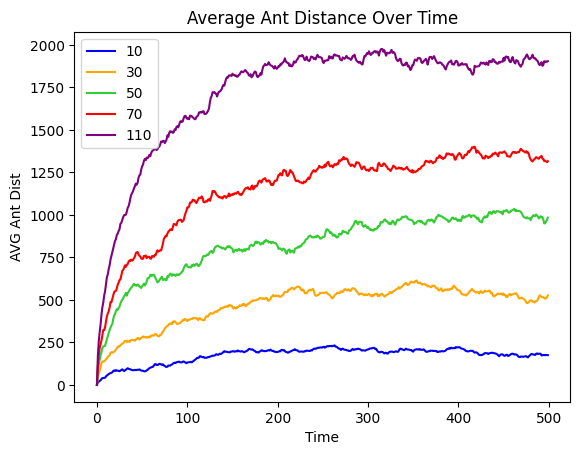

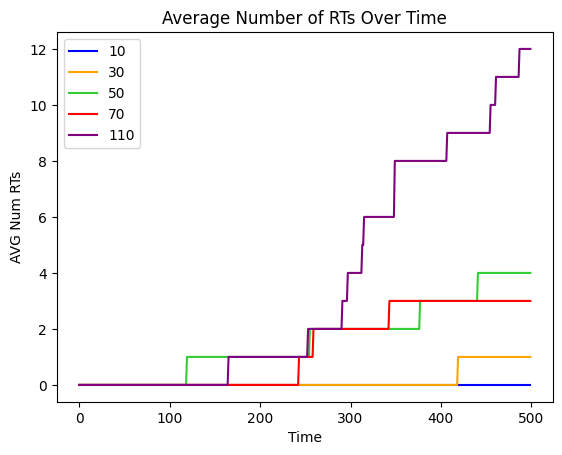

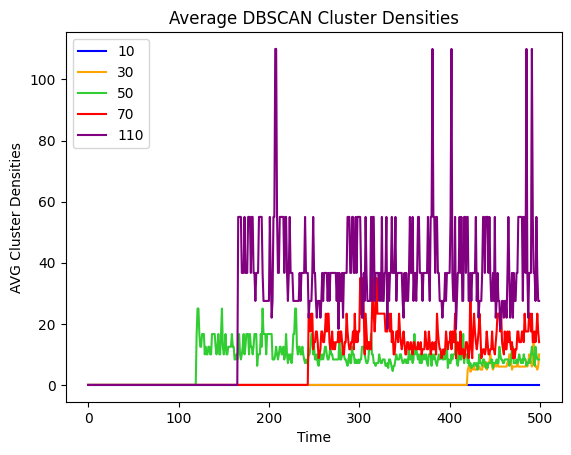

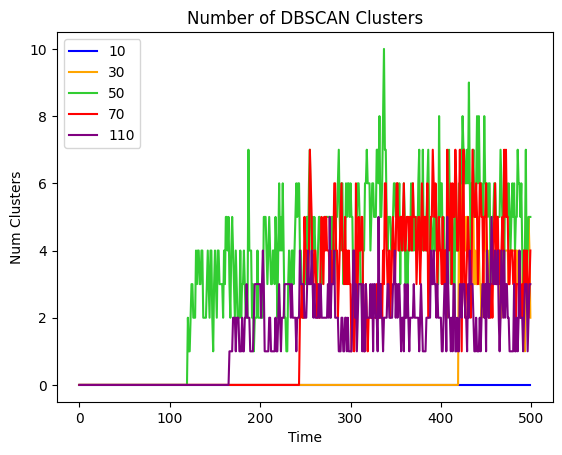

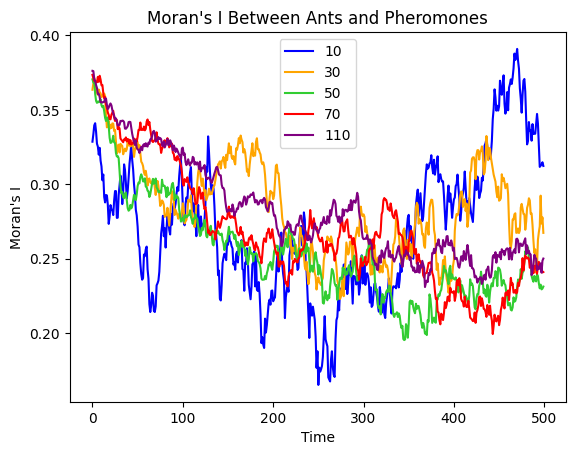

In [8]:
NAME = "main"
NUM_STEPS = 500
# INIT_ANTS = 70
# MAX_ANTS = 70
ANT_POPS = [10, 30, 50, 70, 110]
ANT_POPS_COLOURS = ["blue", "orange", "limegreen", "red", "purple"]
ANT_POP_DISTS = []
AVG_NUM_RT_PER_POP_SIZE_PER_TIME = []
MORAN_IS = []
CLUSTER_DENSITIES = []
NUMBER_CLUSTERS = []

NUM_SIMS = len(ANT_POPS)

run_ctr = 0

# standard prior
PRIOR_TICK = 1
C = np.zeros((cf.NUM_OBSERVATIONS, 1))
prior = 0
for o in range(cf.NUM_OBSERVATIONS):
    C[o] = prior
    prior += PRIOR_TICK

if __name__ == "__main__":

    for i in range(NUM_SIMS):

        num_round_trips, paths, coeff, distances, num_round_trips_per_time, ants, cluster_densities, num_clusters, Morans_i_values = main(
            num_steps=NUM_STEPS,
            init_ants=ANT_POPS[i],
            max_ants=ANT_POPS[i],
            C=C,
            save=True,
            switch=True,
            name=NAME,
            ant_only_gif=False,
            num_runs = NUM_SIMS,
            ctr = run_ctr
        )

        ANT_POP_DISTS.append(distances)
        CLUSTER_DENSITIES.append(cluster_densities)
        NUMBER_CLUSTERS.append(num_clusters)
        AVG_NUM_RT_PER_POP_SIZE_PER_TIME.append(num_round_trips_per_time)
        MORAN_IS.append(Morans_i_values)

        # print(f"ANT_POPS[i]: {ANT_POPS[i]}")
        # print(f"num_round_trips_per_time: {num_round_trips_per_time}")
        # print(f"num_round_trips {num_round_trips} / coeff {coeff / ANT_POPS[i]}")

        # f = open(f"my_imgs_2/{NAME}.txt", "w")
        # f = open(f"my_imgs_dbscan/{NAME}.txt", "w")
        # f = open(f"my_imgs_dbscan_2/{NAME}.txt", "w")

#         f = open(f"my_imgs_dbscan_70_ants/{NAME}.txt", "w")
#         f.write(f"num_round_trips {num_round_trips} / coeff {coeff / ANT_POPS[i]}")
#         f.close()

        run_ctr += 1

    plt.title("Average Ant Distance Over Time")
    plt.xlabel("Time")
    plt.ylabel("AVG Ant Dist")
    for i in range(len(ANT_POPS)):
        plt.plot(
            [step for step in range(NUM_STEPS)], 
            ANT_POP_DISTS[i], 
            label=f'{ANT_POPS[i]}',
            color = ANT_POPS_COLOURS[i]
        )
    plt.legend()
    plt.show()

    plt.title("Average Number of RTs Over Time")
    plt.xlabel("Time")
    plt.ylabel("AVG Num RTs")
    for i in range(len(ANT_POPS)):
        plt.plot(
            [step for step in range(NUM_STEPS)], 
            AVG_NUM_RT_PER_POP_SIZE_PER_TIME[i], 
            label=f'{ANT_POPS[i]}',
            color = ANT_POPS_COLOURS[i]
        )
    plt.legend()
    plt.show()

    plt.title("Average DBSCAN Cluster Densities")
    plt.xlabel("Time")
    plt.ylabel("AVG Cluster Densities")
    for i in range(len(ANT_POPS)):
        plt.plot(
            [step for step in range(NUM_STEPS)], 
            CLUSTER_DENSITIES[i], 
            label=f'{ANT_POPS[i]}',
            color = ANT_POPS_COLOURS[i]
        )
    plt.legend()
    plt.show()

    plt.title("Number of DBSCAN Clusters")
    plt.xlabel("Time")
    plt.ylabel("Num Clusters")
    for i in range(len(ANT_POPS)):
        plt.plot(
            [step for step in range(NUM_STEPS)], 
            NUMBER_CLUSTERS[i], 
            label=f'{ANT_POPS[i]}',
            color = ANT_POPS_COLOURS[i]
        )
    plt.legend()
    plt.show()

    plt.title("Moran's I Between Ants and Pheromones")
    plt.xlabel("Time")
    plt.ylabel("Moran's I")
    for i in range(len(ANT_POPS)):
        plt.plot(
            [step for step in range(NUM_STEPS)], 
            MORAN_IS[i], 
            label=f'{ANT_POPS[i]}',
            color = ANT_POPS_COLOURS[i]
        )
    plt.legend()
    plt.show()